# Banking Customer EDA 

This notebook explores a retail-banking customer dataset to understand:
- **Who the customers are** (demographics & segments)
- **How they use products** (accounts, cards, loans)
- **What differentiates higher-value customers** (assets, credit usage, loyalty tiers)

Along the way I built a few **derived features** (tenure, total assets, leverage) and highlight actionable insights.

!pip install pymssql

In [5]:
!pip install pandas

## 1) Load data
   
The data is loaded from the schema table of a database derived by establishing a database connection.

In [6]:
import pandas as pd
import pymssql

query = "SELECT * FROM banking_case.dbo.customer;"

conn = pymssql.connect(
    server="127.0.0.1",
    port="1433",
    user="pratishtha",
    password="Pratishtha22@",
    database="banking_case"
)

df = pd.read_sql(query, conn)   # run BEFORE closing
conn.close()

df.head()

C:\Users\prati\AppData\Local\Temp\ipykernel_1684\280761853.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)   # run BEFORE closing


,Client_ID,Name,Age,Location_ID,Joined_Bank,Banking_Contact,Nationality,Occupation,Fee_Structure,Loyalty_Classification,...,Bank_Deposits,Checking_Accounts,Saving_Accounts,Foreign_Currency_Account,Business_Lending,Properties_Owned,Risk_Weighting,BRId,GenderId,IAId
0,IND81288,Raymond Mills,24,34324,2019-05-06,Anthony Torres,American,Safety Technician IV,High,Jade,...,1.485829e+06,6.036179e+05,607332.437500,12249.959961,1.134475e+06,1,2,1,1,1
1,IND65833,Julia Spencer,23,42205,2001-12-10,Jonathan Hawkins,African,Software Consultant,High,Jade,...,6.414828e+05,2.295214e+05,344635.156250,61162.308594,2.000526e+06,1,3,2,1,2
2,IND47499,Stephen Murray,27,7314,2010-01-25,Anthony Berry,European,Help Desk Operator,High,Gold,...,1.033402e+06,6.526747e+05,203054.343750,79071.781250,5.481376e+05,1,3,3,2,3
3,IND72498,Virginia Garza,40,34594,2019-03-28,Steve Diaz,American,Geologist II,Mid,Silver,...,1.048158e+06,1.048158e+06,234685.015625,57513.648438,1.148402e+06,0,4,4,1,4
4,IND60181,Melissa Sanders,46,41269,2012-07-20,Shawn Long,American,Assistant Professor,Mid,Platinum,...,4.877825e+05,4.466442e+05,128351.453125,30012.140625,1.674412e+06,0,3,1,2,5


In [7]:
!pip install seaborn
!pip install matplotlib
!pip install numpy

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df.shape

(3000, 25)

## 2) Quick cleaning + derived features

- Parse `Joined Bank` as a date  
- Create **tenure** (years since joining)  
- Create **financial aggregates**:
  - `total_assets` = deposits + checking + saving + foreign currency
  - `total_liabilities` = bank loans + credit card balance
  - `net_assets` = total_assets − total_liabilities  
- Create an **income band** for segmentation

In [32]:
# --- Parse dates ---
df["Joined_Bank"] = pd.to_datetime(df["Joined_Bank"], dayfirst=True, errors="coerce")

# --- Tenure (years) ---
today = pd.Timestamp.today().normalize()
df["tenure_years"] = (today - df["Joined_Bank"]).dt.days / 365.25

# --- Financial aggregates ---
asset_cols = ["Bank_Deposits", "Checking_Accounts", "Saving_Accounts", "Foreign_Currency_Account"]
liability_cols = ["Bank_Loans", "Credit_Card_Balance"]

df["total_assets"] = df[asset_cols].sum(axis=1)
df["total_liabilities"] = df[liability_cols].sum(axis=1)
df["net_assets"] = df["total_assets"] - df["total_liabilities"]

# Simple leverage proxy (avoid divide-by-zero)
df["liability_to_asset_ratio"] = df["total_liabilities"] / (df["total_assets"].replace(0, np.nan))

df[["Joined_Bank","tenure_years","total_assets","total_liabilities","net_assets","liability_to_asset_ratio"]].head()

,Joined_Bank,tenure_years,total_assets,total_liabilities,net_assets,liability_to_asset_ratio
0,2019-05-06,6.795346,2.709029e+06,7.767275e+05,1.932301e+06,0.286718
1,2001-12-10,24.197125,1.276802e+06,1.272872e+06,3.929397e+03,0.996922
2,2010-01-25,16.071184,1.968202e+06,1.057285e+06,9.109178e+05,0.537183
3,2019-03-28,6.902122,2.388514e+06,1.254001e+05,2.263114e+06,0.052501
4,2012-07-20,13.587953,1.092790e+06,1.052081e+06,4.070895e+04,0.962748


In [12]:
bins = [0, 100000, 300000, float('inf')]

labels =['Low','Medium','High']

df['Income_Band']= pd.cut(df['Estimated_Income'], bins = bins, labels = labels , right = False)

<Axes: xlabel='Income_Band'>

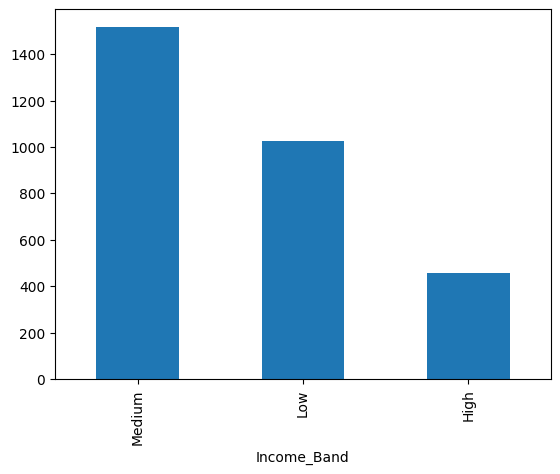

In [13]:
df['Income_Band'].value_counts().plot(kind ='bar')

## 3) Data quality snapshot

We check:
- shape and column types  
- missing values  
- duplicates  
- basic descriptive statistics

In [34]:
display(df.shape)
display(df.dtypes)

missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0])

dup_rows = df.duplicated().sum()
dup_ids = df.duplicated(subset=["Client_ID"]).sum()

print(f"Duplicate rows: {dup_rows}")
print(f"Duplicate Client IDs: {dup_ids}")

df.describe(include="all").T.head(15)

(3000, 31)

Client_ID                             str
Name                                  str
Age                                 int64
Location_ID                         int64
Joined_Bank                 datetime64[s]
Banking_Contact                       str
Nationality                           str
Occupation                            str
Fee_Structure                         str
Loyalty_Classification                str
Estimated_Income                  float64
Superannuation_Savings            float64
Amount_of_Credit_Cards              int64
Credit_Card_Balance               float64
Bank_Loans                        float64
Bank_Deposits                     float64
Checking_Accounts                 float64
Saving_Accounts                   float64
Foreign_Currency_Account          float64
Business_Lending                  float64
Properties_Owned                    int64
Risk_Weighting                      int64
BRId                                int64
GenderId                          

Series([], dtype: int64)

Duplicate rows: 0
Duplicate Client IDs: 60


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Client_ID,3000,2940,IND48103,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name,3000,2913,Raymond Mills,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,3000.0,NaN,NaN,NaN,51.039667,17.0,34.0,51.0,69.0,85.0,19.85476
Location_ID,3000.0,NaN,NaN,NaN,21563.323,12.0,10803.5,21129.5,32054.5,43369.0,12462.273017
Joined_Bank,3000,NaN,NaN,NaN,2010-08-15 00:03:21,1995-01-03 00:00:00,2004-04-01 18:00:00,2011-02-18 00:00:00,2017-12-24 06:00:00,2021-12-31 00:00:00,NaN
Banking_Contact,3000,49,Ernest Rivera,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nationality,3000,5,European,1309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,3000,195,Associate Professor,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fee_Structure,3000,3,High,1476,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Loyalty_Classification,3000,4,Jade,1331,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4) Categorical distributions (top categories for readability)

In [14]:
# examining the distribution of unique categories in categorical columns 

categorical_cols = df[["BRId","GenderId","Amount_of_Credit_Cards","Nationality","Occupation","Fee_Structure","Loyalty_Classification","Properties_Owned","Risk_Weighting","Income_Band"]]

for cols in categorical_cols:
    print(f"Value counts for '{cols}': ")
    display(df[cols].value_counts())

Value counts for 'BRId': 


BRId
3    1352
1     660
2     495
4     493
Name: count, dtype: int64

Value counts for 'GenderId': 


GenderId
2    1512
1    1488
Name: count, dtype: int64

Value counts for 'Amount_of_Credit_Cards': 


Amount_of_Credit_Cards
1    1922
2     765
3     313
Name: count, dtype: int64

Value counts for 'Nationality': 


Nationality
European      1309
Asian          754
American       507
Australian     254
African        176
Name: count, dtype: int64

Value counts for 'Occupation': 


Occupation
Associate Professor             28
Structural Analysis Engineer    28
Recruiter                       25
Account Coordinator             24
Human Resources Manager         24
                                ..
Office Assistant IV              8
Automation Specialist I          7
Computer Systems Analyst I       6
Developer III                    5
Senior Sales Associate           4
Name: count, Length: 195, dtype: int64

Value counts for 'Fee_Structure': 


Fee_Structure
High    1476
Mid      962
Low      562
Name: count, dtype: int64

Value counts for 'Loyalty_Classification': 


Loyalty_Classification
Jade        1331
Silver       767
Gold         585
Platinum     317
Name: count, dtype: int64

Value counts for 'Properties_Owned': 


Properties_Owned
2    777
1    776
3    742
0    705
Name: count, dtype: int64

Value counts for 'Risk_Weighting': 


Risk_Weighting
2    1222
1     836
3     460
4     322
5     160
Name: count, dtype: int64

Value counts for 'Income_Band': 


Income_Band
Medium    1517
Low       1027
High       456
Name: count, dtype: int64

### Countplots by Gender

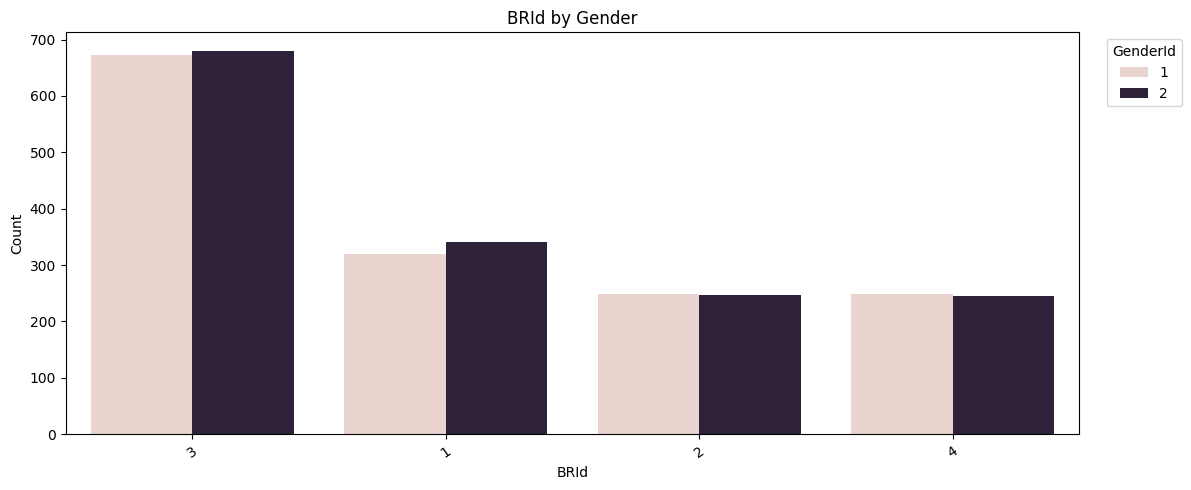

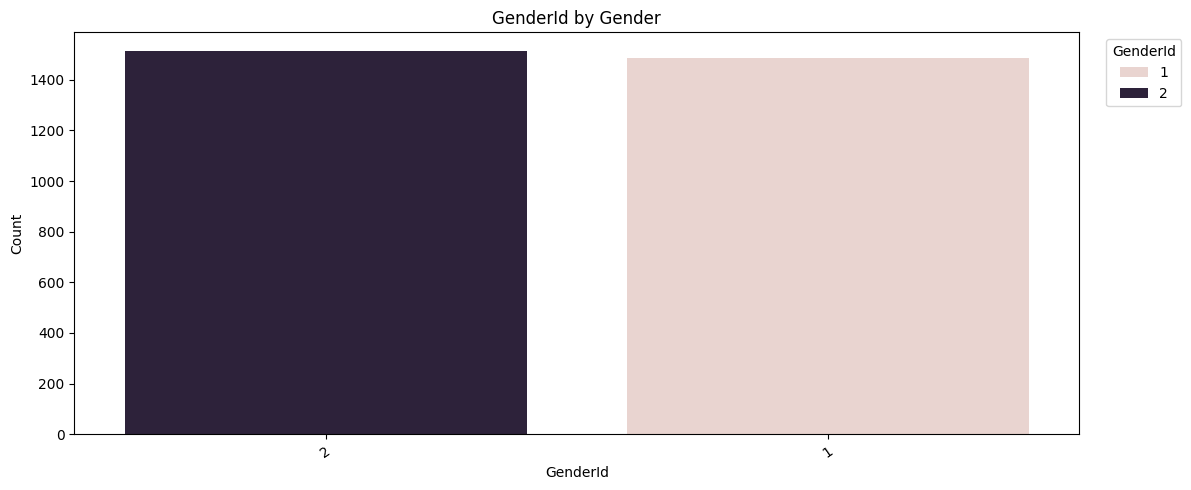

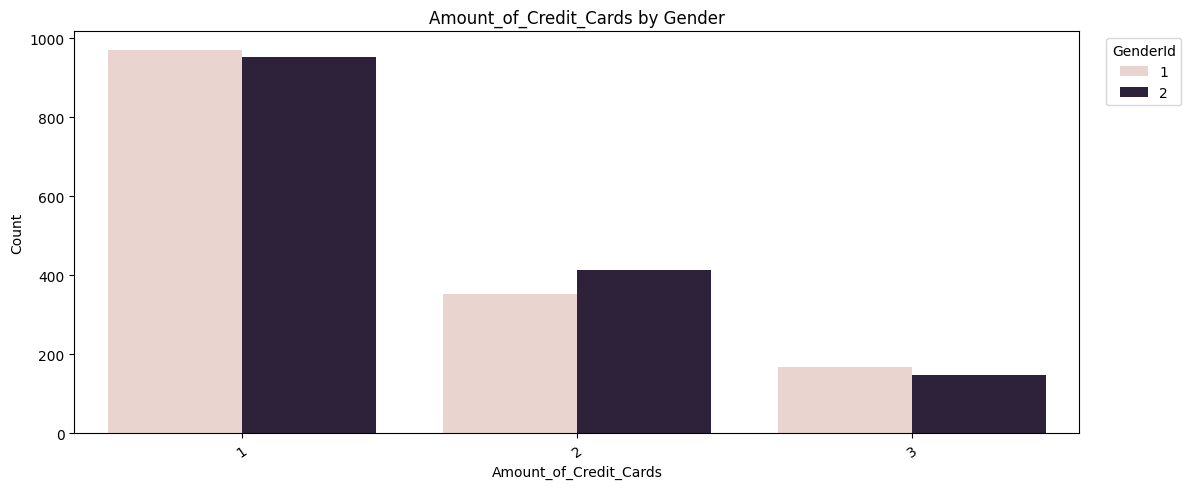

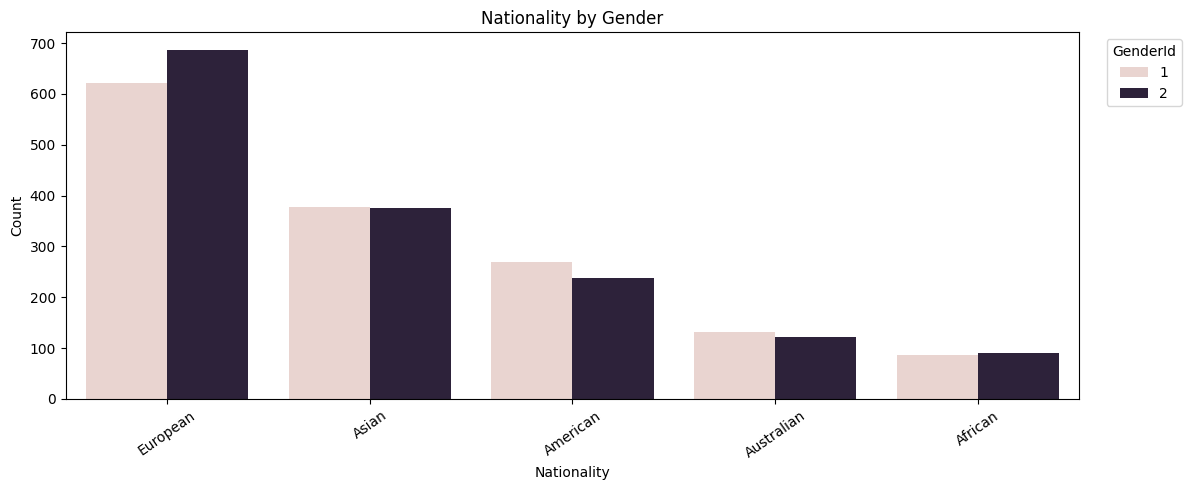

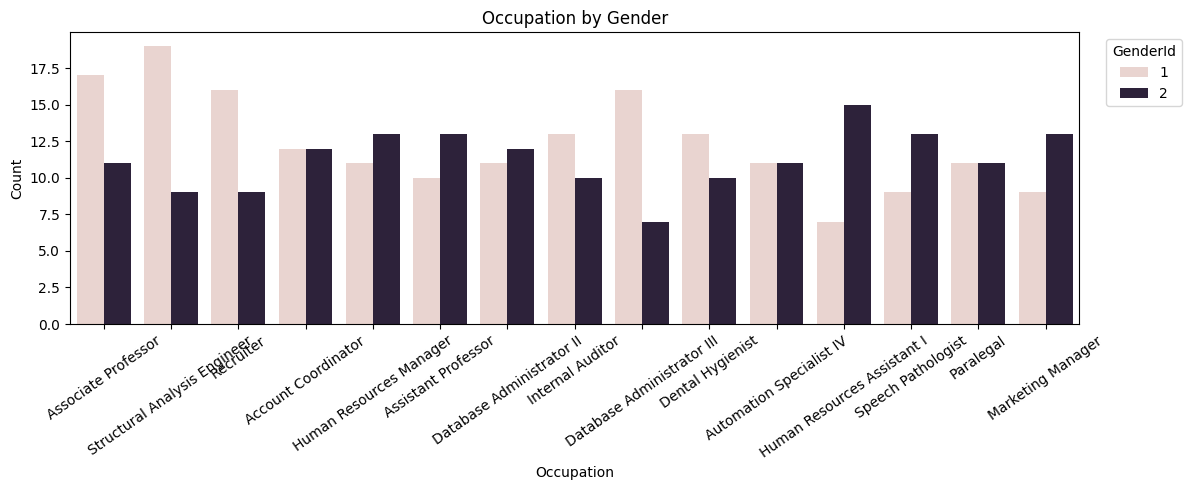

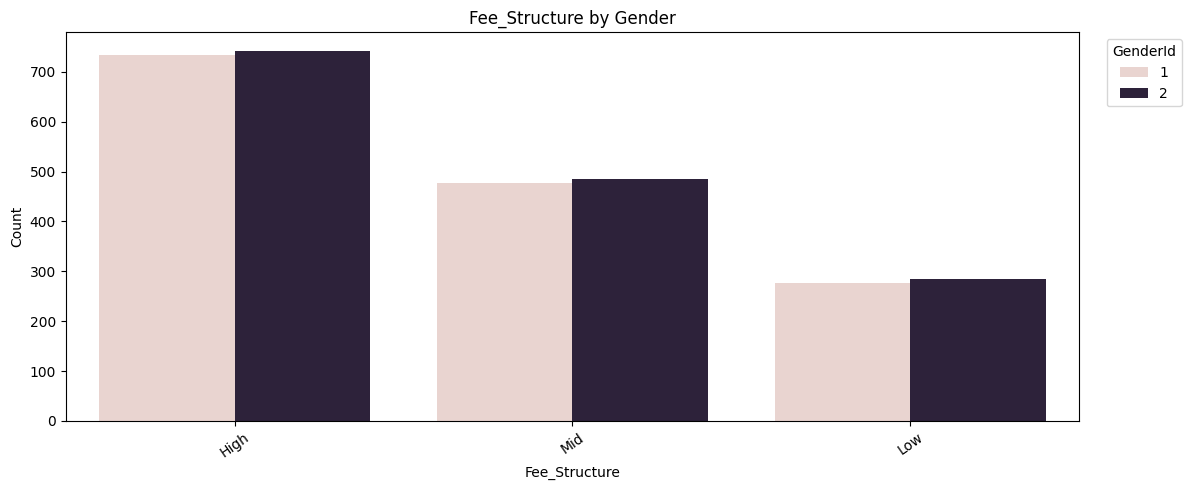

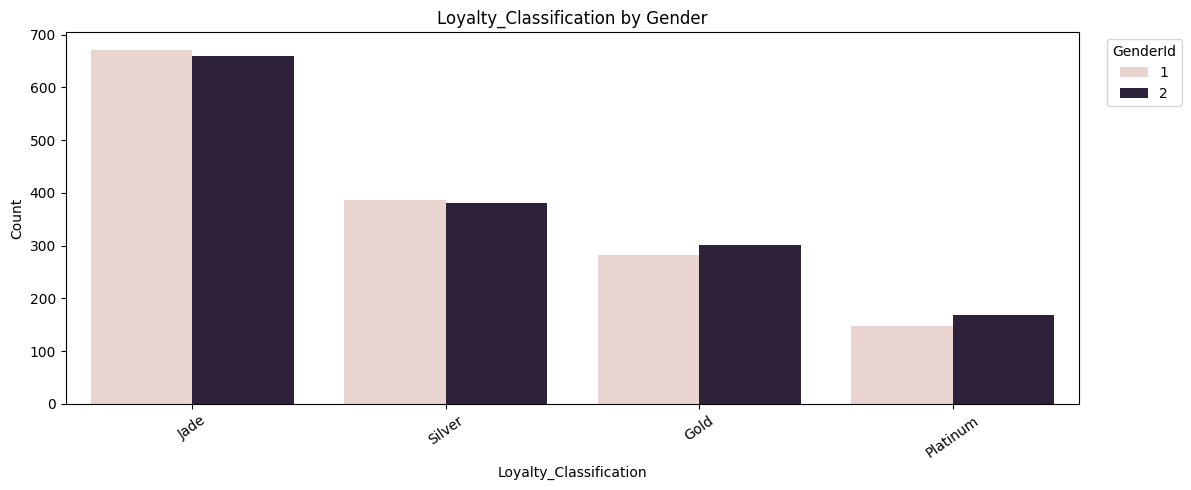

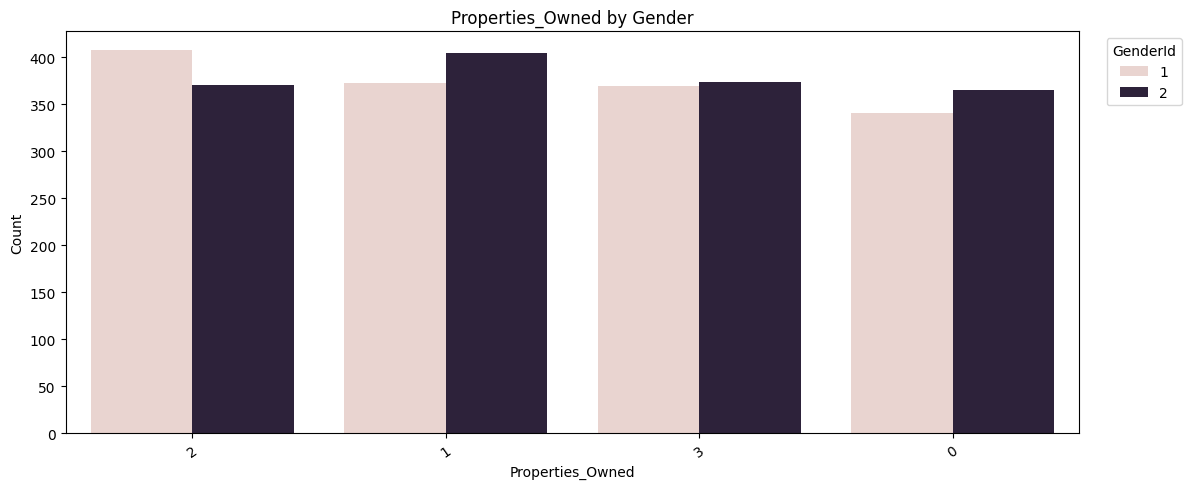

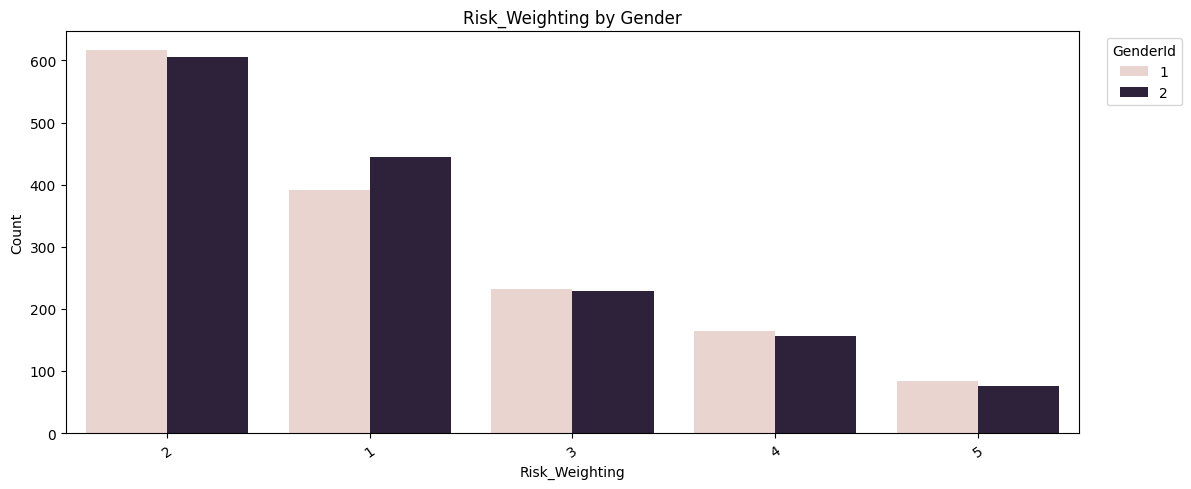

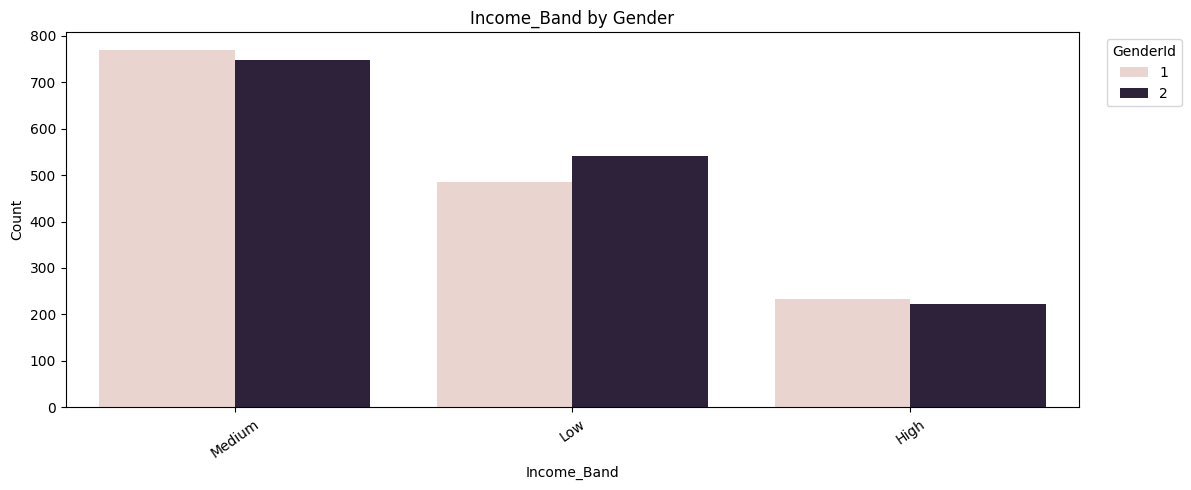

In [35]:
def makecountplot(data, x, hue=None, top_n=15, title=None):
    vc = data[x].value_counts(dropna=False)
    order = vc.head(top_n).index
    plt.figure(figsize=(12,5))
    ax = sns.countplot(data=data, x=x, hue=hue, order=order)
    ax.set_title(title or f"{x} distribution" + (f" by {hue}" if hue else ""))
    ax.set_xlabel(x)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=35, labelsize=10)
    plt.legend(title=hue, bbox_to_anchor=(1.02, 1), loc="upper left") if hue else None
    plt.tight_layout()
    plt.show()

for predictor in categorical_cols:
    makecountplot(df, predictor, hue="GenderId", top_n=15, title=f"{predictor} by Gender")

### Countplots by Nationality

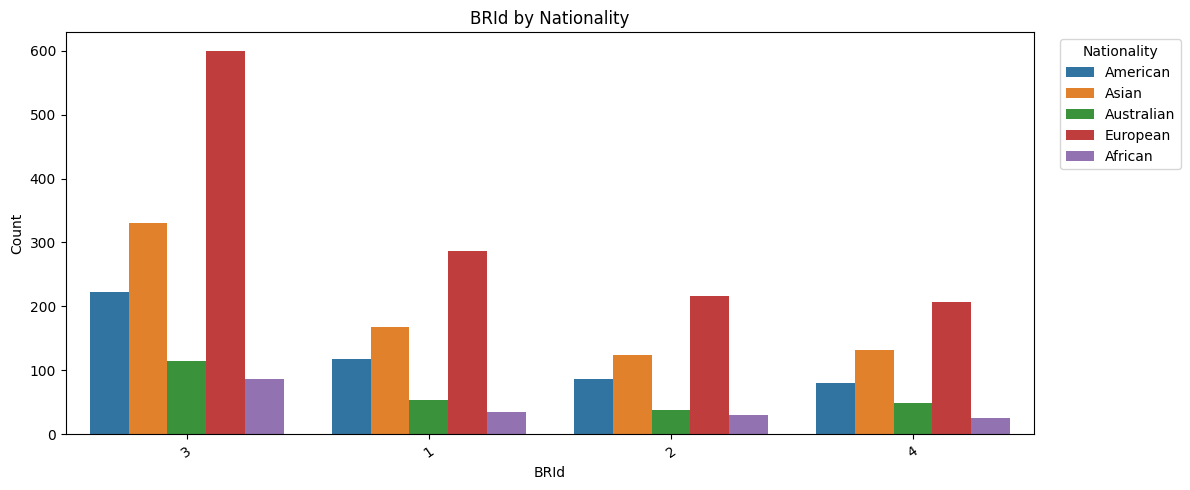

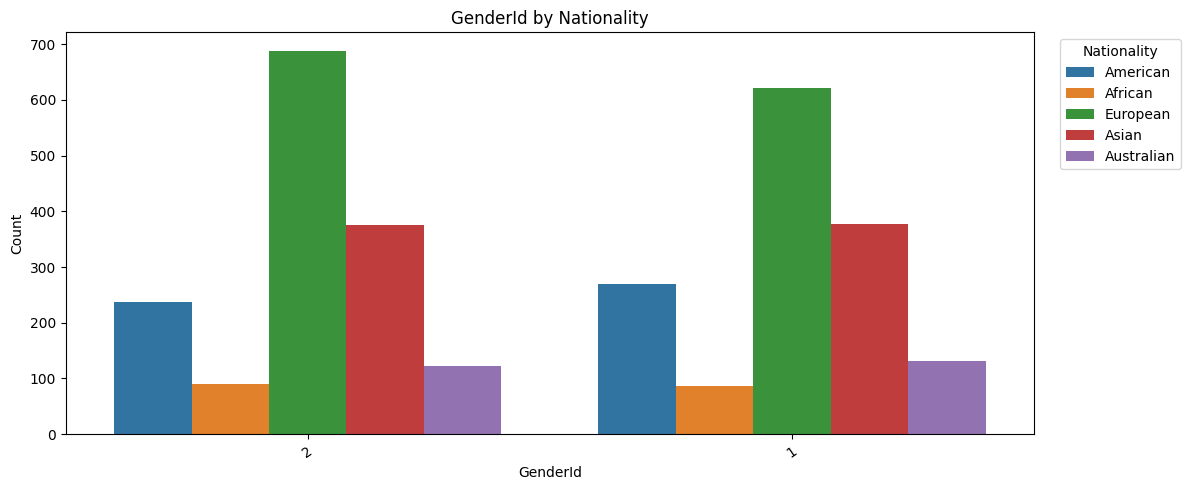

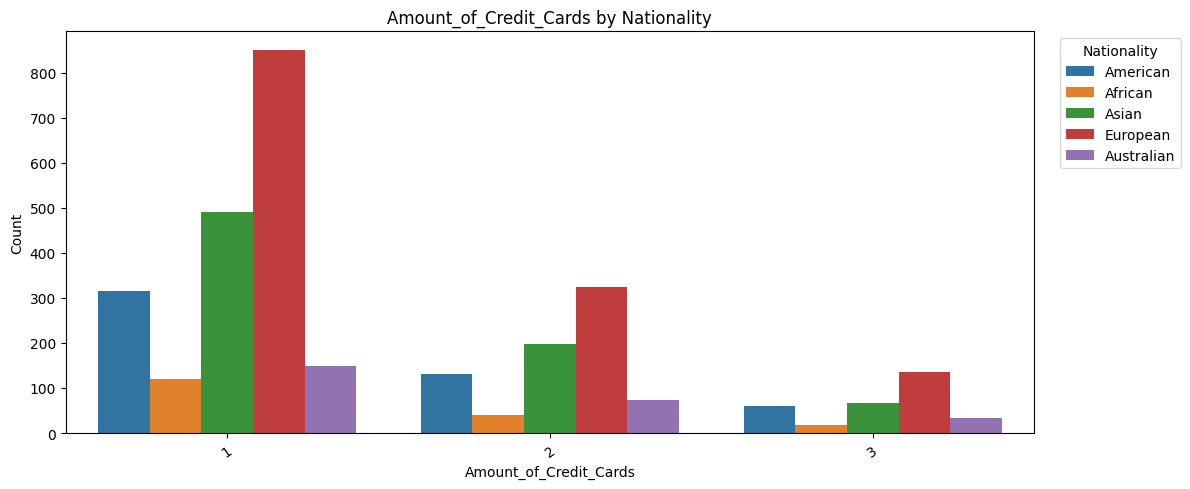

C:\Users\prati\AppData\Local\Temp\ipykernel_1684\2967323125.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=hue, bbox_to_anchor=(1.02, 1), loc="upper left") if hue else None


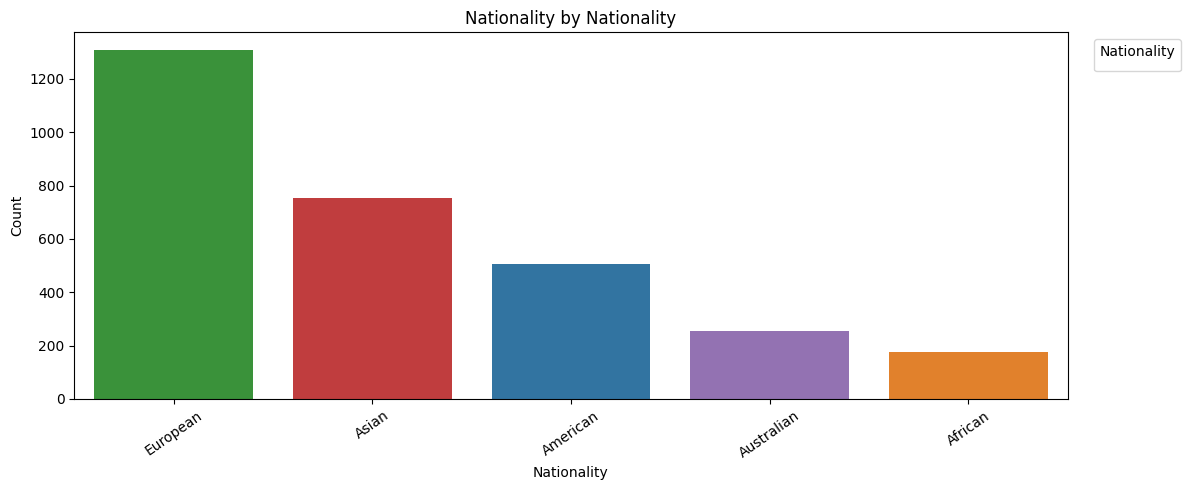

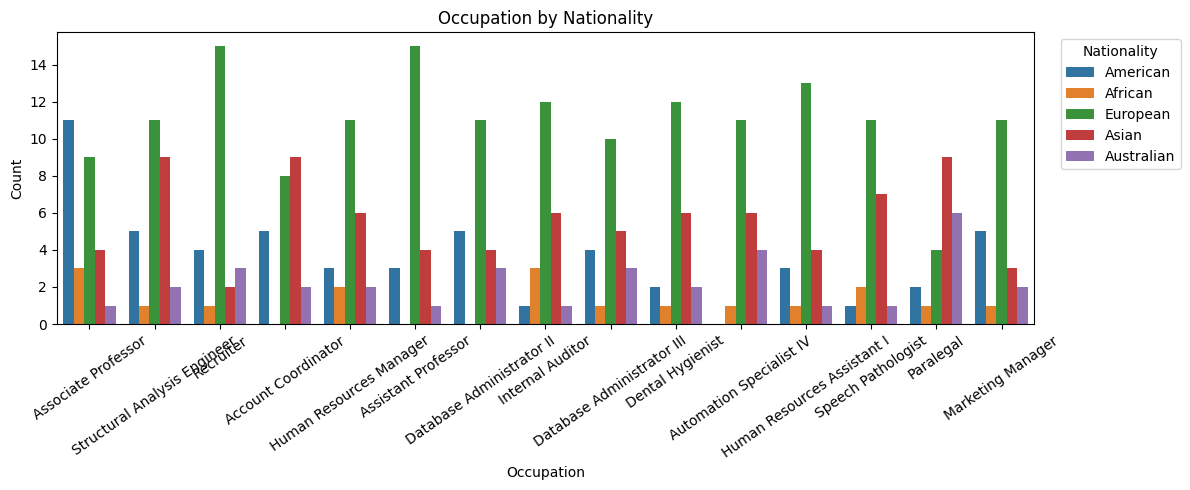

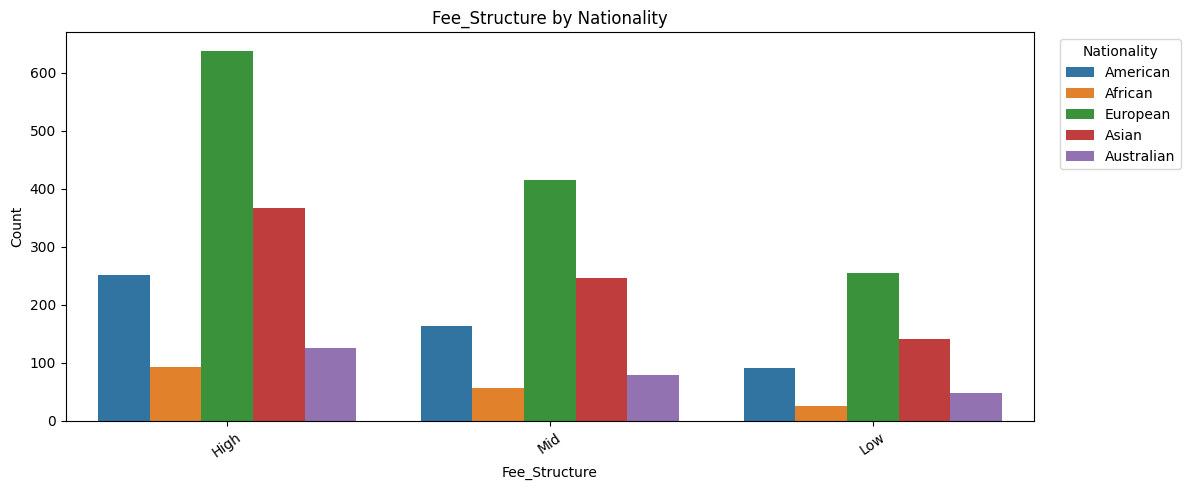

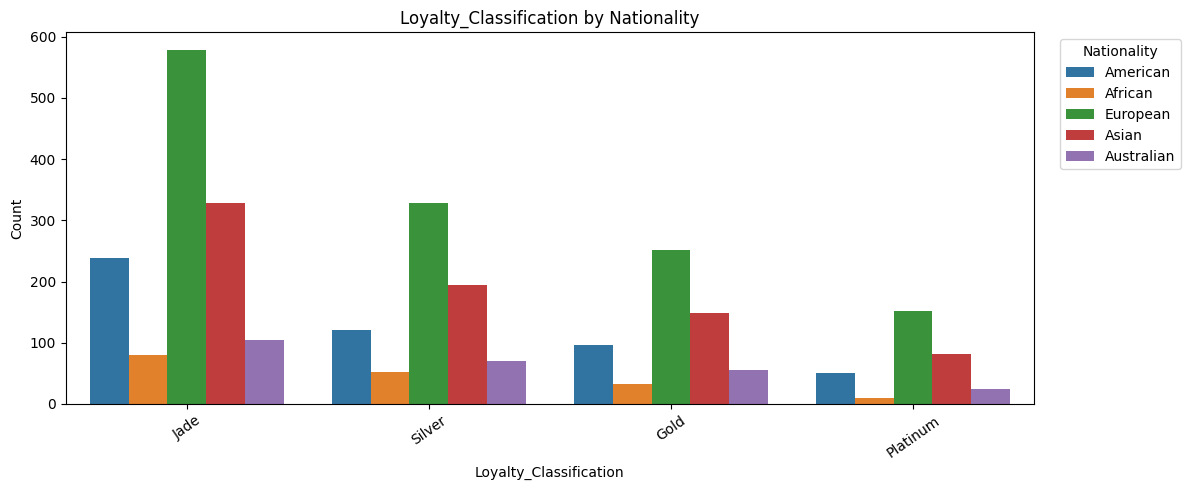

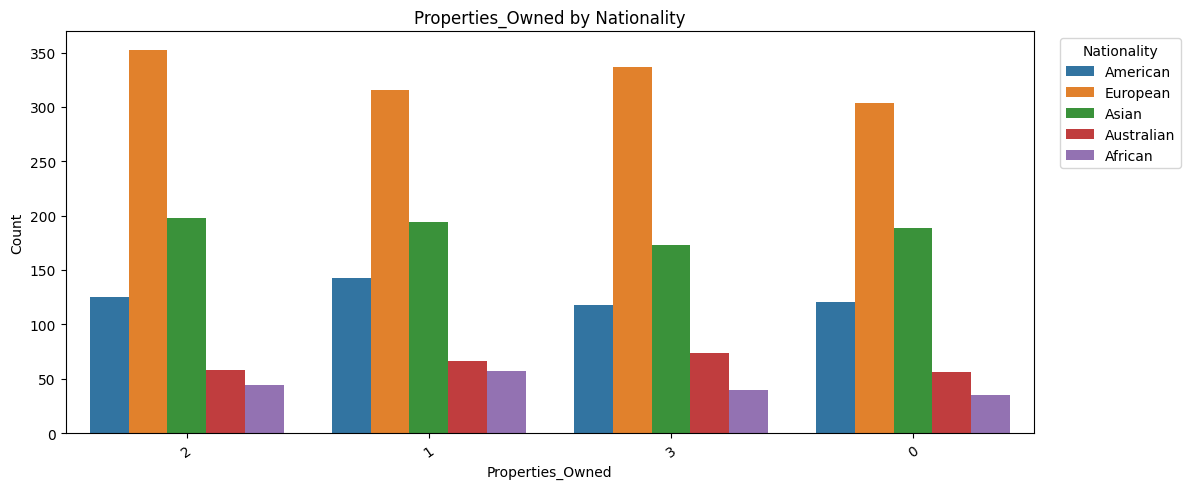

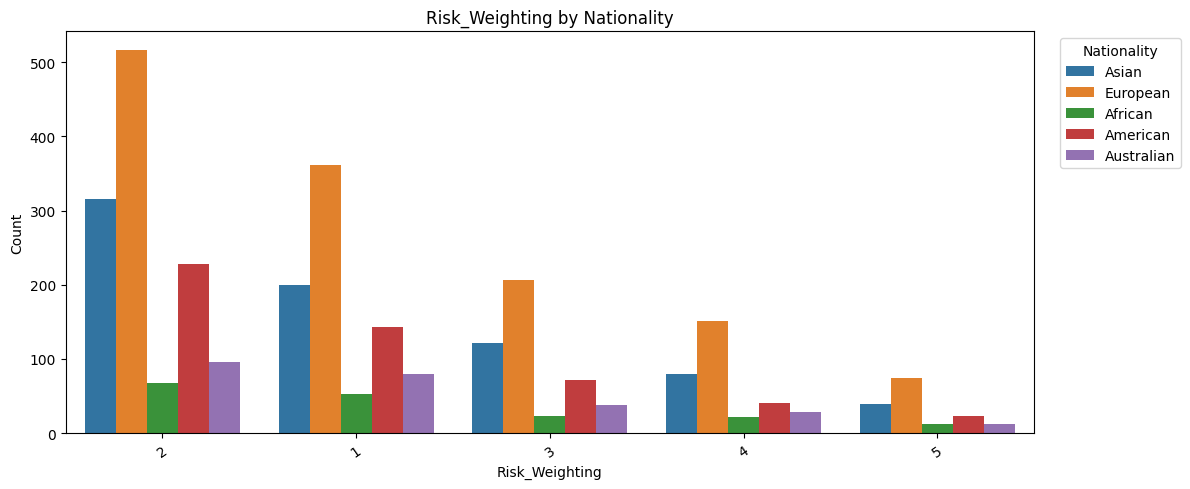

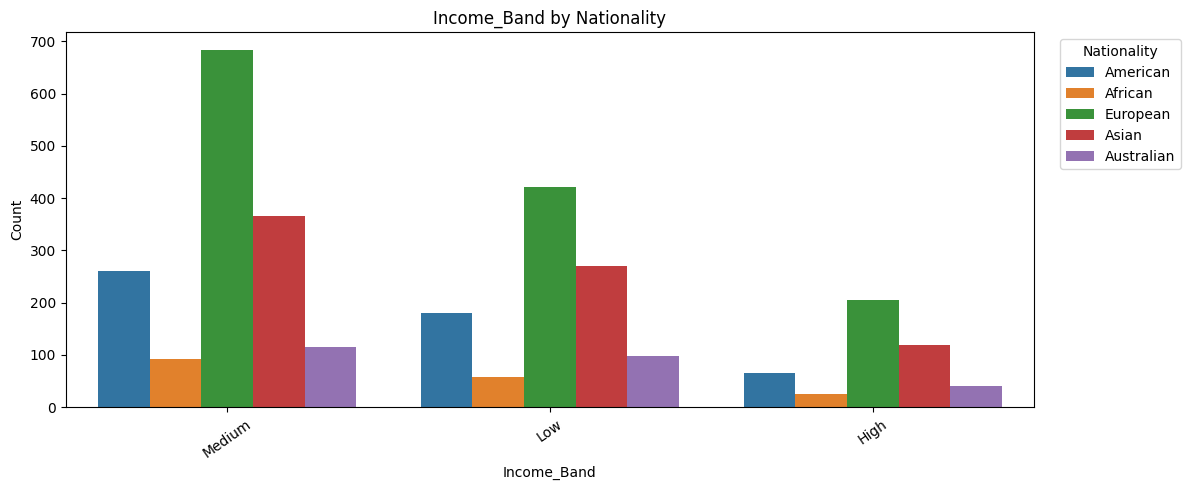

In [36]:
for predictor in categorical_cols:
    makecountplot(df, predictor, hue="Nationality", top_n=15, title=f"{predictor} by Nationality")

### High-cardinality example: Occupation (top 20)

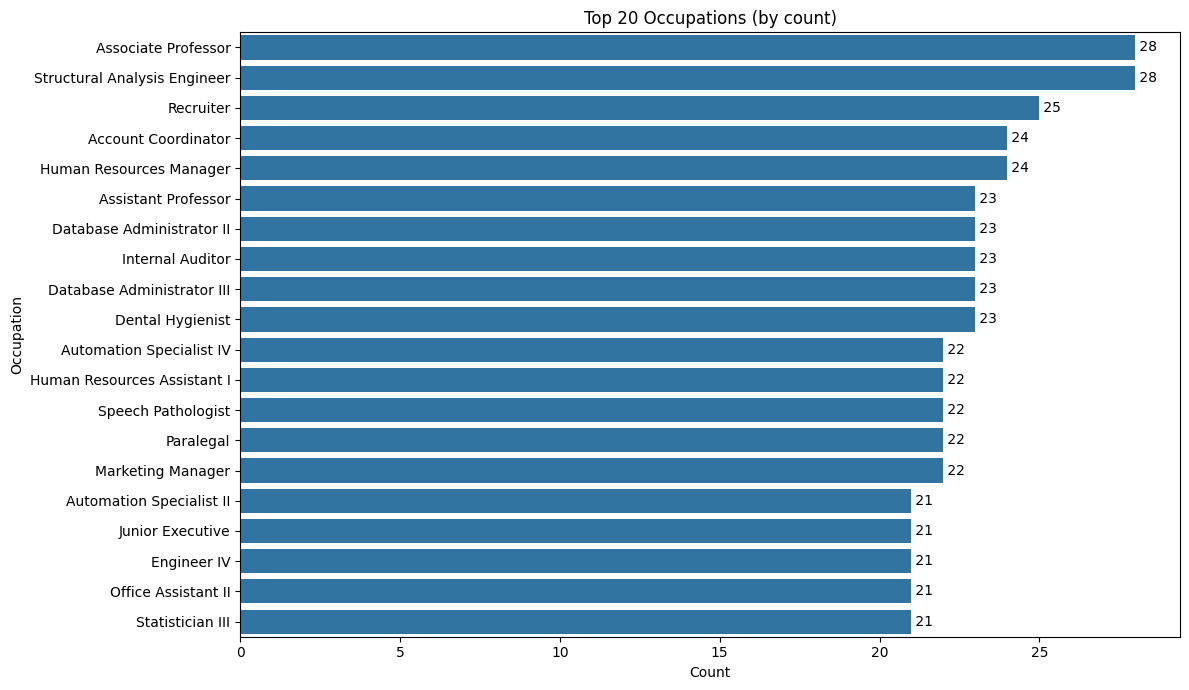

In [37]:
top_occ = df["Occupation"].value_counts().head(20)
plt.figure(figsize=(12,7))
ax = sns.barplot(x=top_occ.values, y=top_occ.index)
ax.set_title("Top 20 Occupations (by count)")
ax.set_xlabel("Count")
ax.set_ylabel("Occupation")
for i, v in enumerate(top_occ.values):
    ax.text(v, i, f" {v}", va="center")
plt.tight_layout()
plt.show()

## 5) Numerical distributions

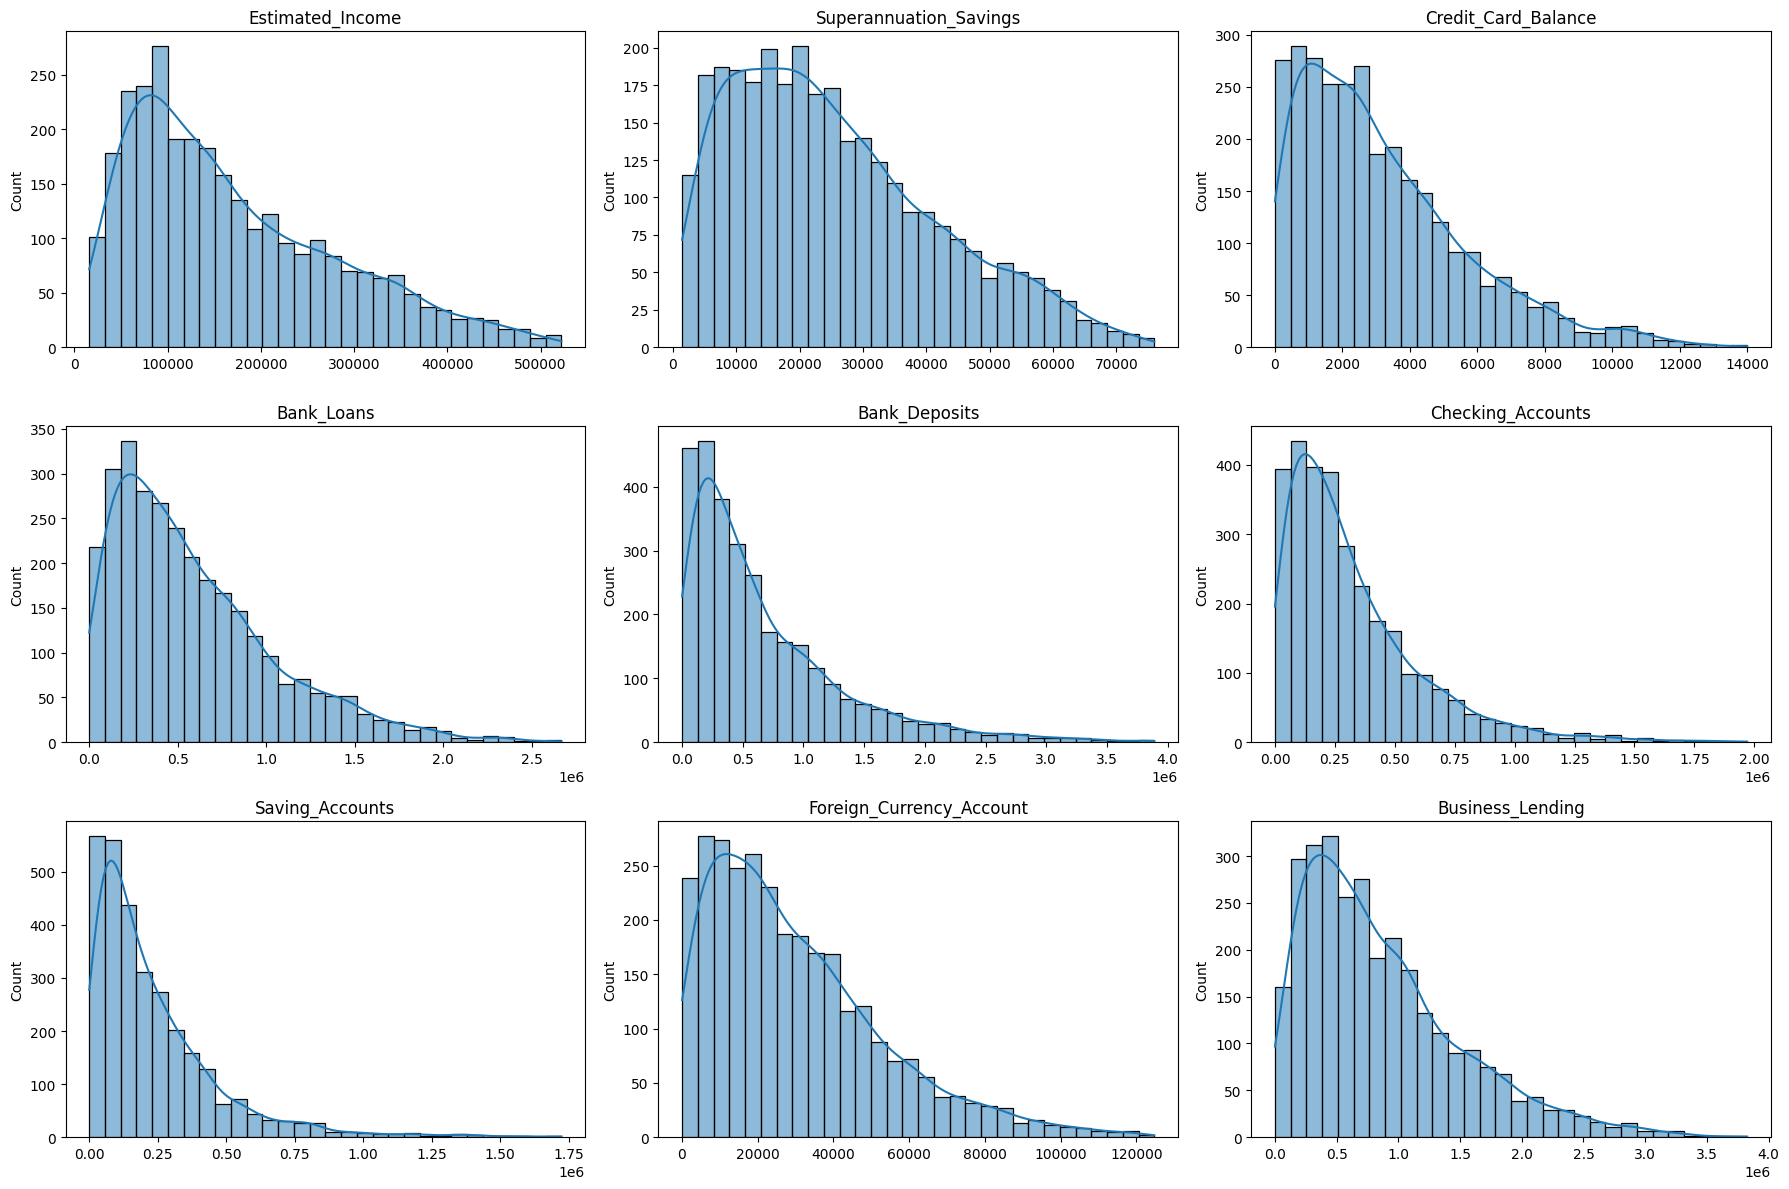

In [38]:
numerical_cols = [
    "Estimated_Income", "Superannuation_Savings", "Credit_Card_Balance",
    "Bank_Loans", "Bank_Deposits", "Checking_Accounts", "Saving_Accounts",
    "Foreign_Currency_Account", "Business_Lending"
]

n = len(numerical_cols)
rows = int(np.ceil(n/3))
plt.figure(figsize=(18, 4*rows))

for i, col in enumerate(numerical_cols, start=1):
    plt.subplot(rows, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
    plt.xlabel("")
plt.tight_layout()
plt.show()

### Compare key financial metrics across Income Bands

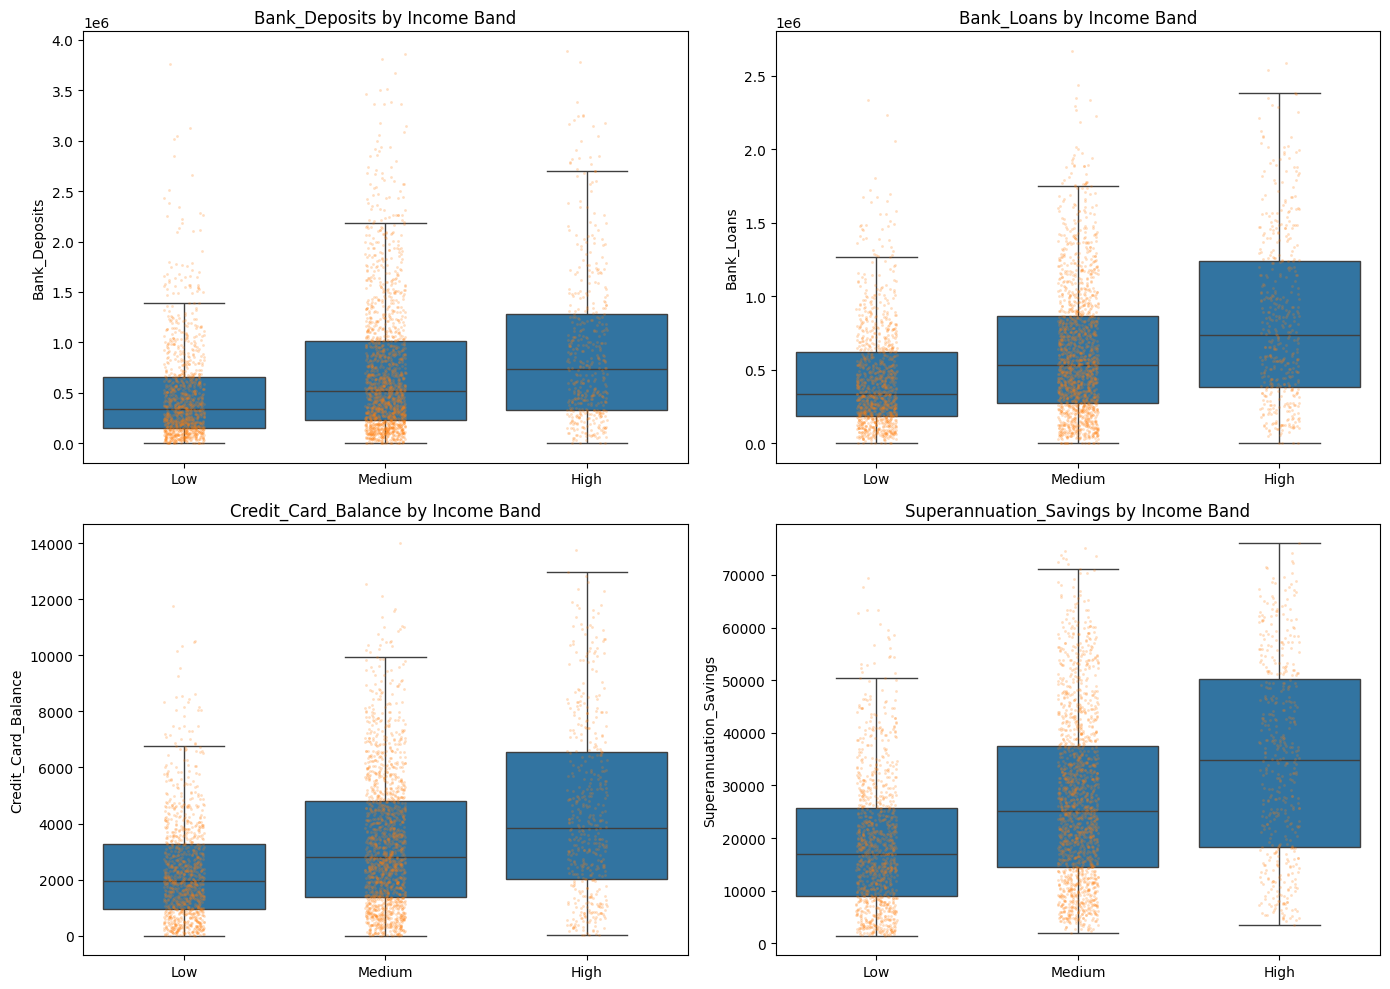

In [39]:
compare_cols = ["Bank_Deposits", "Bank_Loans", "Credit_Card_Balance", "Superannuation_Savings"]

plt.figure(figsize=(14,10))
for i, col in enumerate(compare_cols, start=1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x="Income_Band", y=col, order=labels, showfliers=False)
    sns.stripplot(data=df, x="Income_Band", y=col, order=labels, size=2, alpha=0.25)
    plt.title(f"{col} by Income Band")
    plt.xlabel("")
plt.tight_layout()
plt.show()

## 6) Correlation analysis

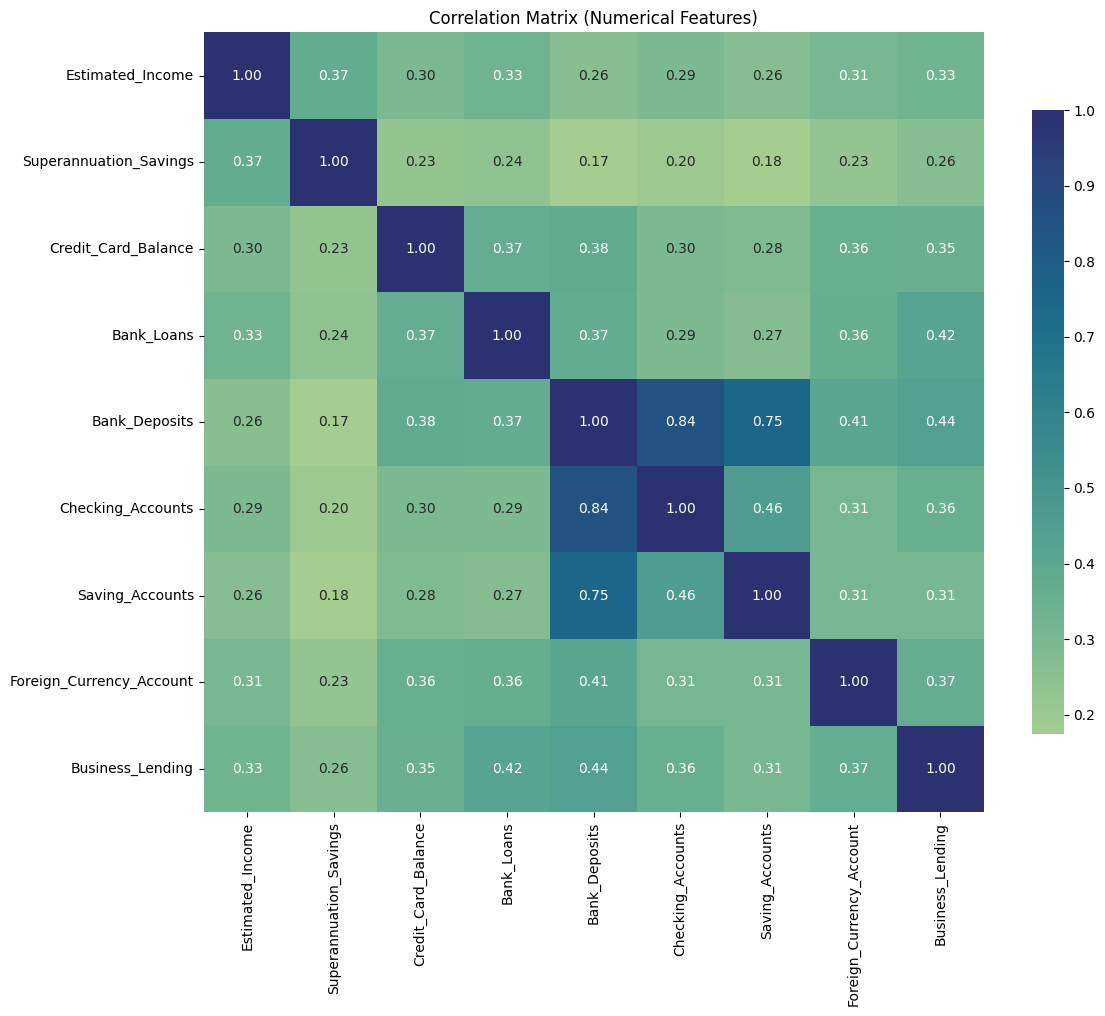

In [41]:
corr = df[numerical_cols].corr(numeric_only=True)

plt.figure(figsize=(12,10))
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap="crest", square=True, cbar_kws={"shrink": 0.8})
ax.set_title("Correlation Matrix (Numerical Features)")
plt.tight_layout()
plt.show()

### A few relationship plots (interpretable pairs)

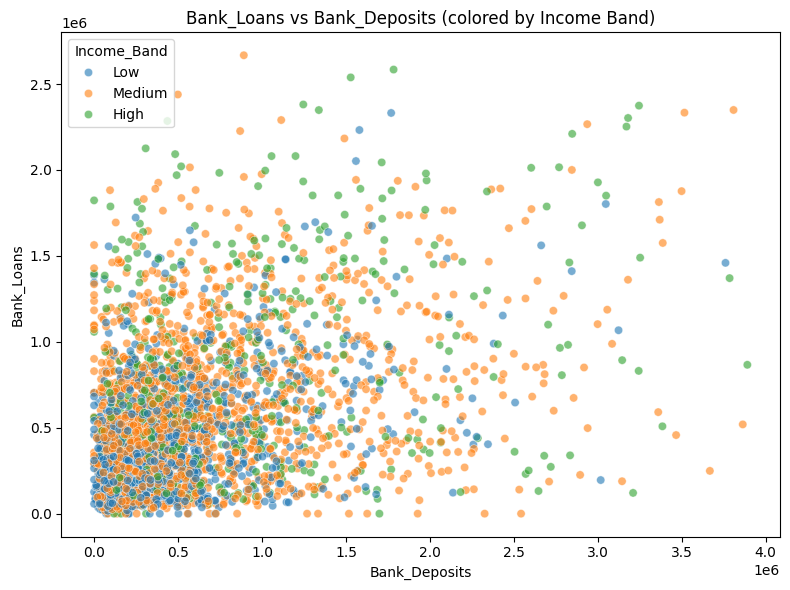

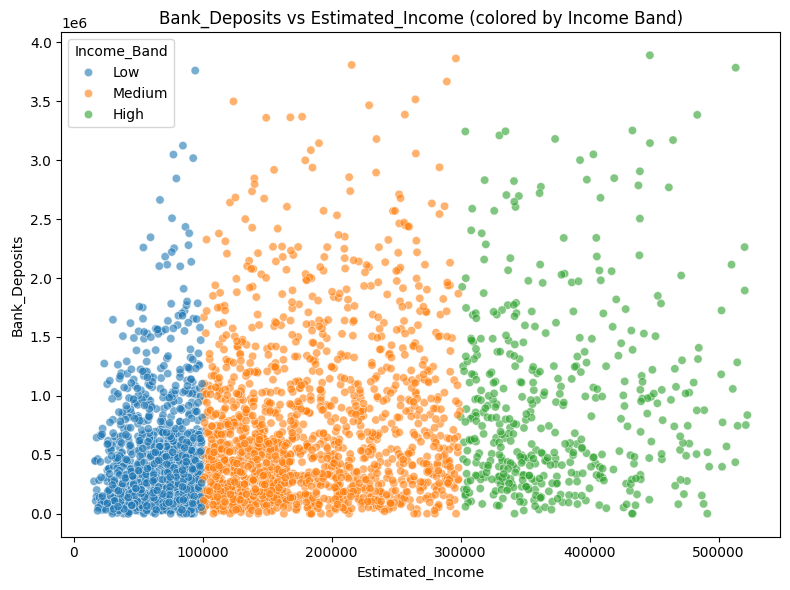

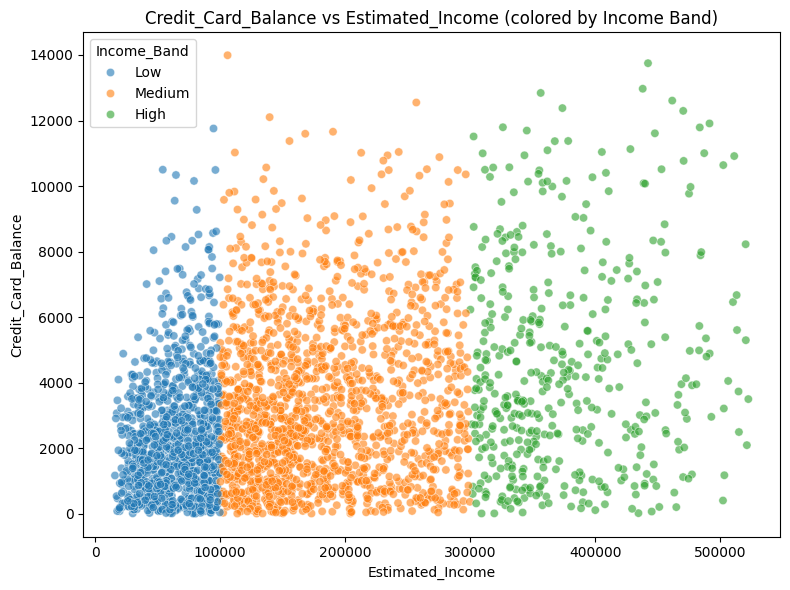

In [42]:
pairs = [
    ("Bank_Deposits", "Bank_Loans"),
    ("Estimated_Income", "Bank_Deposits"),
    ("Estimated_Income", "Credit_Card_Balance"),
]

for x, y in pairs:
    plt.figure(figsize=(8,6))
    ax = sns.scatterplot(data=df, x=x, y=y, hue="Income_Band", alpha=0.6)
    ax.set_title(f"{y} vs {x} (colored by Income Band)")
    plt.tight_layout()
    plt.show()

## 8) Key Insights (from EDA)

- **Customer value distribution is heavy-tailed**: medians are often more stable than means for balances.  
- **Higher income bands (Q4) tend to have higher assets and larger product footprints**, but also often higher liabilities—so *net assets* is a better “value” proxy than assets alone.  
- **Loyalty tiers should correlate with value** (if designed well). If a tier shows low net assets or low product footprint, it may indicate tier assignment rules need review.  
- **Account balances across types can move together** (deposits/checking/saving), suggesting “asset consolidation” behavior in some segments.  
- **Tenure adds context**: newer customers may have fewer products; long-tenure customers are better candidates for cross-sell and retention interventions. 

In [44]:
# Homepage, loan analysis, deposit analysis, summay, ask AB